# 자전거 공유 시스템 RF 모델 학습
20197123_최은기
참고한 유저 데이터: https://www.kaggle.com/code/sumn2u/bike-sharing-demand-random-forest

기존 예제에서 최대한 학습할 수 있는 내용에 대해 번역 및 학습하며 추가적인 Markdown(텍스트) 을 삽입했습니다.

In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Import visualization libraries 데이터 흐름 학습 목적으로 기존 예제코드 첨부
import seaborn as sns
import matplotlib.pyplot as plt

# 가설 세워보기

워싱턴 DC의 자전거 공유 서비스 수요는 기상 조건, 시간대, 요일, 특별 이벤트나 공휴일 등 다양한 요인에 의해 영향을 받을 수 있습니다.

* **Weather Conditions**: 자전거 공유 서비스에 대한 수요는 날씨의 영향을 받을 수 있습니다. 사람들은 비나 눈이 오는 등 기상 조건이 좋지 않은 날보다 맑고 온화한 날과 같이 쾌적한 날에 자전거를 대여할 가능성이 더 높습니다. 따라서 자전거 대여 수요와 양호한 기상 조건 사이에는 양의 상관관계가 있을 것으로 예상할 수 있습니다.

* **Time of Day**: 자전거 대여 수요는 시간대에 따라 달라집니다. 사람들이 직장이나 학교를 오가는 출퇴근 시간에는 다른 시간대에 비해 자전거에 대한 수요가 더 높습니다. 이는 시간대가 자전거 대여 수요를 예측할 때 고려해야 할 중요한 요소임을 시사합니다.

* **Day of the Week**: 자전거 대여 수요는 요일에 따라 다릅니다. 평일에 비해 여가 시간이 많고 레크리에이션 활동으로 자전거를 이용하는 경우가 많은 주말에 자전거 수요가 더 높습니다. 이는 자전거 대여 수요를 예측할 때 요일도 고려해야 할 또 다른 중요한 요소임을 나타냅니다.

* **Special Events or Holidays**: 자전거 대여 수요는 특별 이벤트나 공휴일의 영향을 받을 수 있습니다. 예를 들어 축제, 스포츠 이벤트 또는 사람들이 외출할 가능성이 높은 기타 특별한 날에는 자전거에 대한 수요가 더 높을 수 있습니다. 따라서 자전거 대여 수요를 예측할 때는 특별 이벤트나 공휴일 발생을 고려해야 합니다.

# 데이터세트 이해해보기

데이터 세트에는 2년(2011년과 2012년)의 시간별 대여 데이터가 포함되어 있습니다. 훈련 데이터 세트는 매월 첫 19일을 포함하고, 테스트 데이터 세트는 매월 20일부터 말일까지의 기간을 포함합니다. 목표는 테스트 세트의 각 시간 동안 대여된 자전거의 총 수를 예측하는 것입니다.

훈련 데이터 세트에서 자전거 수요는 등록 사용자와 일반 사용자에 대해 별도로 주어지며, 총 수는 두 가지를 합한 값입니다. 훈련 데이터 세트에는 12개의 변수가 있는 반면, 테스트 데이터 세트에는 등록, 캐주얼, 카운트를 제외한 9개의 변수가 있습니다.

아래는 각 데이터의 정의임!

- **datetime**:   date and hour in "mm/dd/yyyy hh:mm" format
- **season**:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
- **holiday**:    whether the day is a holiday or not (1/0)
- **workingday**: whether the day is neither a weekend nor holiday (1/0)
- **weather**:    Four Categories of weather
                  1-> Clear, Few clouds, Partly cloudy
                  2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                  3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                  4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**:       hourly temperature in Celsius
- **atemp**:      "feels like" temperature in Celsius
- **humidity**:   relative humidity
- **windspeed**:  wind speed
- **casual**:     number of casual users
- **registered**: number of registered users
- **count**:      total number of bikes rented

Here, **casual**, **registered** and **count** are independent variables.

# 탐색적 데이터 분석

In [2]:
input_dir = '/kaggle/input/bike-sharing-demand/'

# 학습 데이터 불러오기
train_data = pd.read_csv(os.path.join(input_dir, 'train.csv'))

# 학습 데이터임을 의미하는 컬럼 부여
train_data['data_set'] = 'train'

# 5개 훔쳐보기
train_data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


In [3]:
# 테스트 데이터 불러오기
test_data = pd.read_csv(os.path.join(input_dir, 'test.csv'))

# 테스트 데이터임을 의미하는 칼럼 부여
test_data['data_set'] = 'test'

# 5개 훔쳐보기
test_data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,data_set
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,test
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,test
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,test


From above we can see that **test_data** is missing **casual**, **registered** and **count** columns. Let's add those value and see the combined results.

In [4]:
# 원본 데이터 수정을 방지하기 위한 복사본
test_df_copy = test_data.copy()

# 테스트에 필요한 컬럼 부여
test_df_copy['registered'] = 0
test_df_copy['casual'] = 0
test_df_copy['count'] = 0

# 학습 데이터와 합치기
all_df = pd.concat([  train_data,test_df_copy], ignore_index=True)

# 훔쳐보기 (tail 찍음 테스트데이터 보임)
all_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


무슨 컬럼이 있나 살펴봐요

In [5]:
all_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'data_set'],
      dtype='object')

시계열 분석을 위해 새 열을 만들어 보기!
이 열은 기존 **datetime** 열에서 파싱되며 특정 시간 범위별로 인덱싱 됨
> 시계열 분석이란? 시간 순서대로 정렬된 데이터에서 의미 있는 요약과 통계 정보를 추출하기 위한 노력을 의미함

In [6]:
#  'datetime' 칼럼에 인덱스 부여
dt = pd.DatetimeIndex(all_df['datetime'])

# DateTimeIndex 에 인덱스 부여
all_df.set_index(dt, inplace=True)

# 찍어보기
all_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


## 왜 DatetimeIndex 로 인덱스를 부여하는가?
[Pandas DateTimeIndex](https://datascienceschool.net/01%20python/04.08%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EC%9E%90%EB%A3%8C%20%EB%8B%A4%EB%A3%A8%EA%B8%B0.html)

시계열 분석을 위해서는 인덱스를 부여해야한다고 한다.

In [7]:
# 오름차순으로 datetimeIndex 정렬
# Select rows from all_df that fall within the time range from '2011-01-01 01:00:00' to '2011-01-01 03:00:00'
# all_df['2011-01-01 01:00:00':'2011-01-01 03:00:00']
# Select rows from all_df that fall within the time range from '2011-01-01 01:00:00' to '2011-01-01 03:00:00'
all_df.loc[(all_df.index >= '2011-01-01 01:00:00') & (all_df.index <= '2011-01-01 03:00:00')]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
datetime,,,,,,,,,,,,,
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train


히스토그램 그려서 데이터를 파악해보자

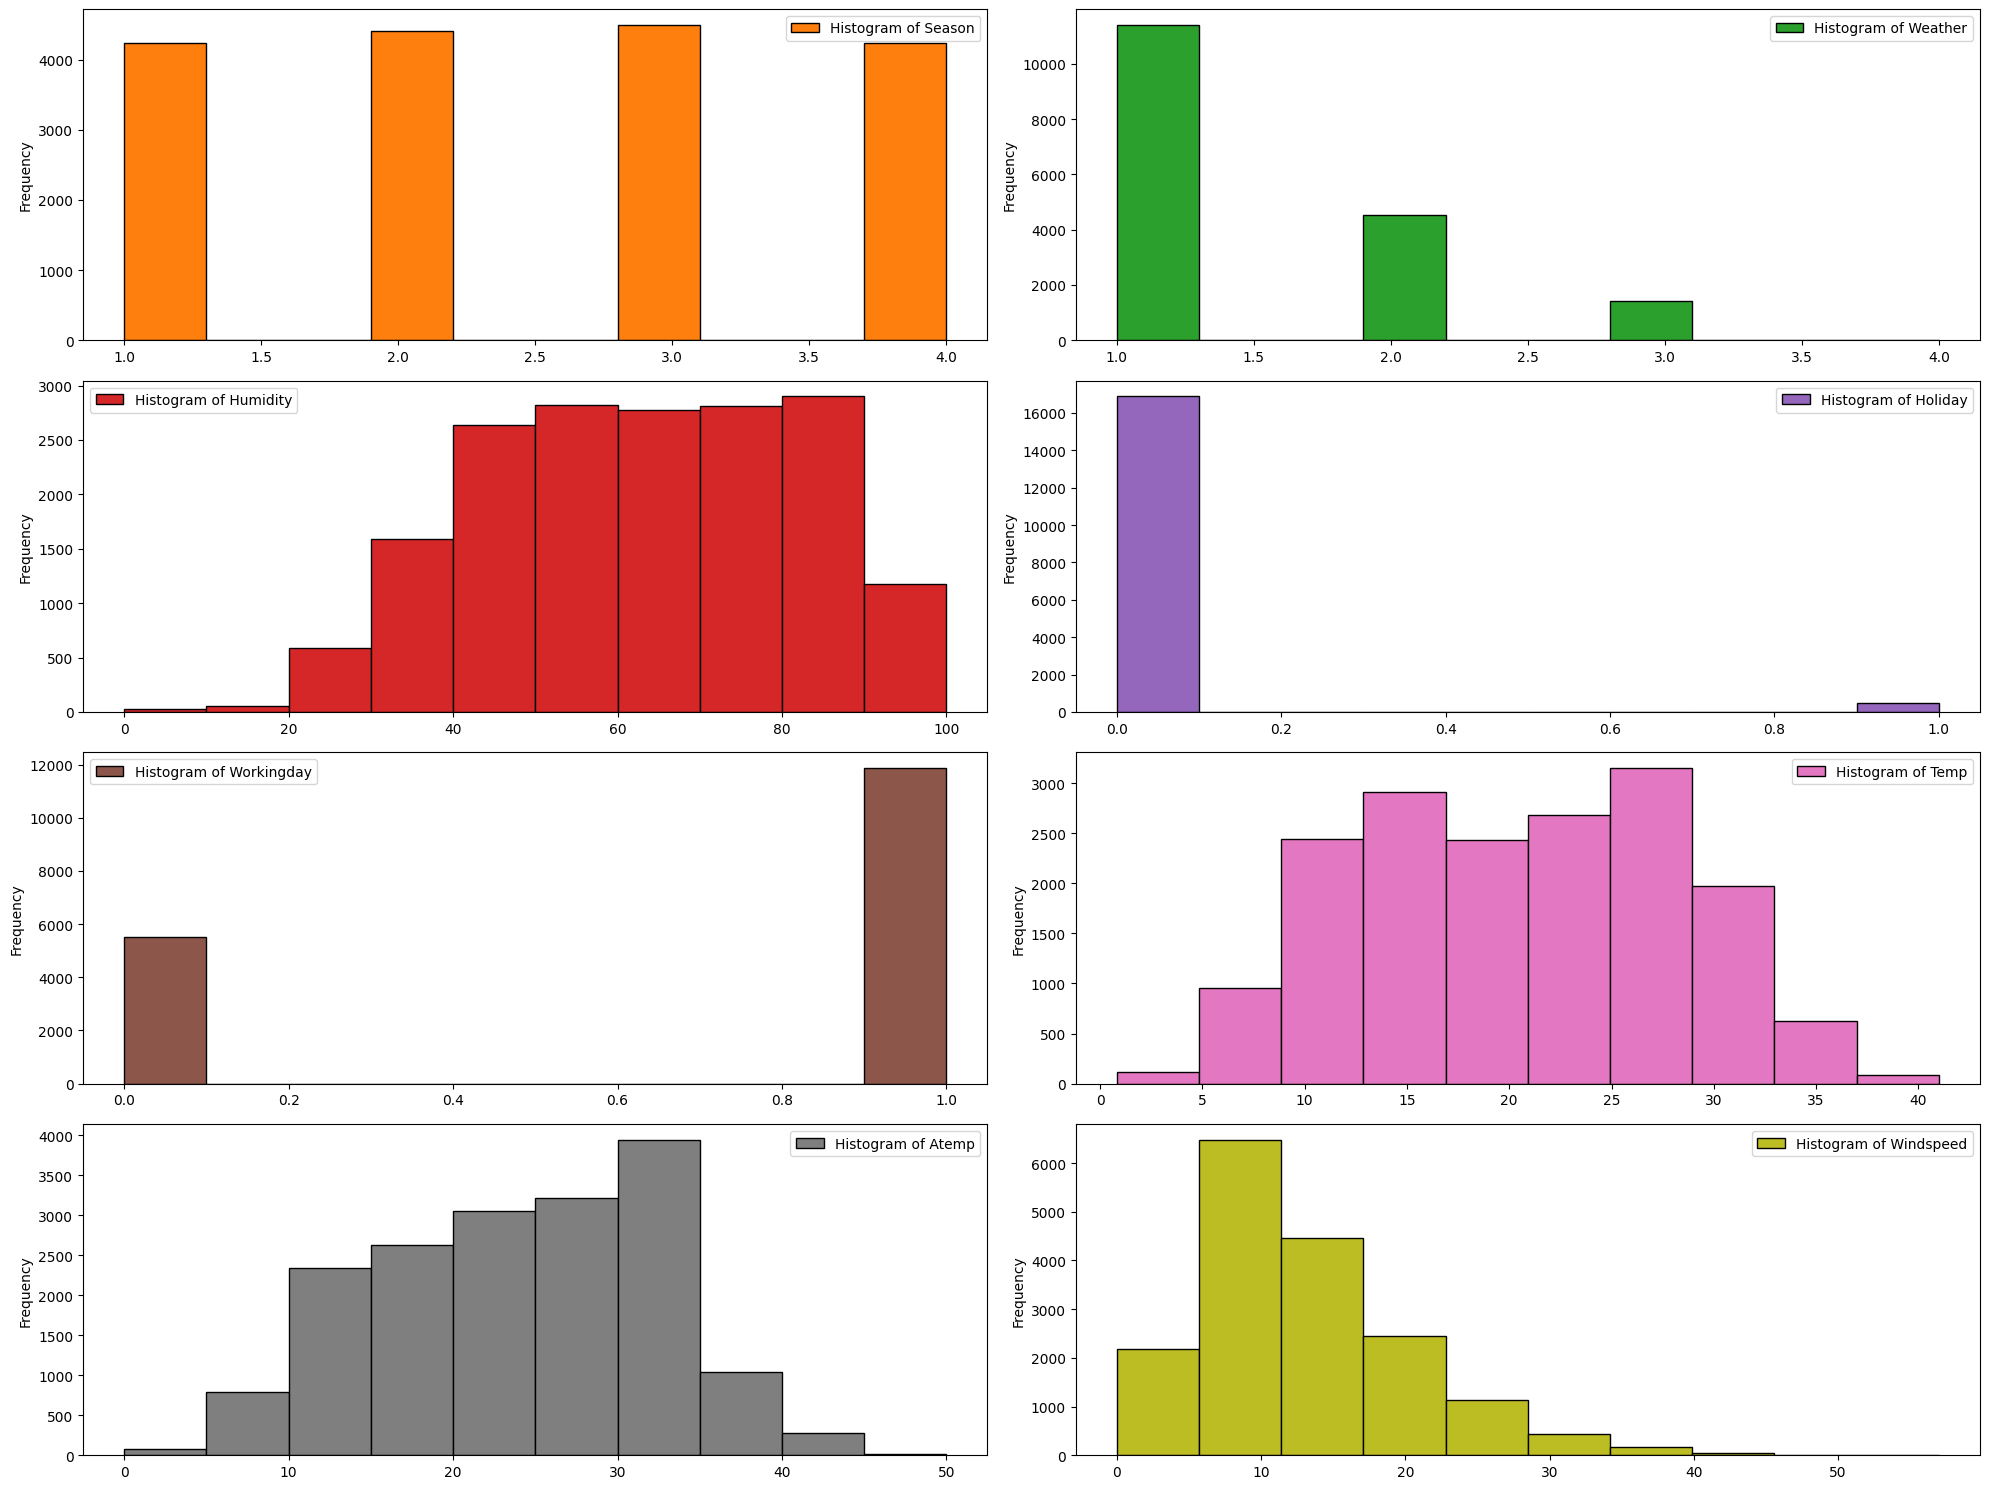

In [8]:
# 히스토그램에 그려볼 컬럼 정의
numeric_cols = ['season', 'weather', 'humidity', 'holiday', 'workingday', 'temp', 'atemp', 'windspeed']

# 사이즈 정의
plt.figure(figsize=(20, 15))

# Loop through the numeric columns and plot histograms
for i, col in enumerate(numeric_cols, start=1):
    plt.subplot(4, 2, i)
    all_df[col].plot.hist(bins=10, color='C'+str(i), label=f'Histogram of {col.capitalize()}', edgecolor='black')
    plt.legend(loc='best')

# 레이아웃 조정
plt.tight_layout()

** 해당 히스토그램에서 얻을 수 있는 추론들! **
- **Season**: 계절의 분포는 비교적 고르게 나타나며, 각 계절은 데이터 세트에서 비슷한 빈도를 보인다.
- **Weather**: 카테고리 1(대부분 맑은 날씨)의 빈도가 가장 높아, 데이터 세트에서 맑은 날씨가 가장 일반적인 조건임을 나타냄.
- **Working Day and Holiday**: 대부분의 날이 근무일이며 휴일이 적음. 휴일은 일반적으로 정규 근무일에 비해 그 수가 적기 때문에 이는 예상되는 일
- **Temperature (temp and atemp)**: 온도 변수(온도 및 온도)는 온도 데이터에서 예상되는 거의 정규 분포로 나타냄.
- **Humidity**: 습도 값의 분포가 다소 왜곡된 것처럼 보이지만, 더 많은 맥락이나 구체적인 분포를 염두에 두지 않으면 그 분포에 대해 단정적으로 말하기는 어려울 듯
- **Windspeed**: 풍속 데이터도 낮은 풍속에서는 주파수가 높고 풍속이 높을수록 꼬리가 길어지는 등 다소 왜곡된 것으로 보임



종속 열의 로그 변환을 수행해 보자. 
> 이는 왜곡된 분포를 정규화하고 대칭으로 만들기 위해 수행된다! (중요한 부분인듯) 

In [9]:
# 로그로 변환된 새로운 컬럼 생성
for col in ['casual', 'registered', 'count']:
    all_df[f'{col}_log'] = np.log(all_df[col] + 1)


In [10]:
# datetime 에서 각 시간 값 추출 및 컬럼으 부여
all_df['date'] = dt.date
all_df['day'] = dt.day
all_df['month'] = dt.month
all_df['year'] = dt.year
all_df['hour'] = dt.hour
all_df['dow'] = dt.dayofweek

In [11]:
# 널 값이 있나?
all_df.isnull().sum()

datetime          0
season            0
holiday           0
workingday        0
weather           0
temp              0
atemp             0
humidity          0
windspeed         0
casual            0
registered        0
count             0
data_set          0
casual_log        0
registered_log    0
count_log         0
date              0
day               0
month             0
year              0
hour              0
dow               0
dtype: int64

# Feature Engineering

피처 엔지니어링은 머신러닝 모델의 성능을 향상시킬 수 있는 새로운 피처(변수)를 기존 데이터에서 생성하는 절차를 의미 함.
새로운 변수를 도입하여 모델의 예측 능력을 향상시킬 수 있음

1. **'peak' column:** 해당 시간이 피크 시간인지 아닌지를 나타냅니다. 피크 시간은 근무일과 휴무일에 따라 다르게 정의함

2. **'holiday' column:** 2012년 10월 30일 샌디, 12월 24일, 26일, 31일 크리스마스 등과 같이 특정 날짜를 휴일로 표시합니다.

3. **'workingday' column:** 12월 24일과 31일의 근무일 상태를 휴무일로 조정함

4. **'ideal' column:** 온도와 풍속을 기반으로 날씨가 이상적인지 여부를 파악함.

5. **'sticky' column:** 근무일에 습도가 높은지 여부를 표시함.

위 예시대로 데이터 분석에 도움이 될만한 데이터를 집합해 컬럼으로 정의해서 삽입하면 모델은 더 잘 학습하게 될 것이다... 너무 어렵다

In [12]:
# 피크 시간대인 지 아닌 지 데이터 처리해서 컬럼으로 삽입..
all_df['peak'] = all_df[['hour', 'workingday']]\
    .apply(lambda df: 1 if ((df['workingday'] == 1 and (df['hour'] == 8 or 17 <= df['hour'] <= 18)) \
                            or (df['workingday'] == 0 and 10 <= df['workingday'] <= 19)) else 0, axis=1)

# sandy
all_df['holiday'] = all_df[['month', 'day', 'holiday', 'year']]\
    .apply(lambda df: 1 if (df['year'] == 2012 and df['month'] == 10 and df['day'] == 30) else 0, axis=1)

# 크리스마스나 다른 휴일인 지
all_df['holiday'] = all_df[['month', 'day', 'holiday']]\
    .apply(lambda df: 1 if (df['month'] == 12 and df['day'] in [24, 26, 31]) else df['holiday'], axis=1)
all_df['workingday'] = all_df[['month', 'day', 'workingday']]\
    .apply(lambda df: 0 if df['month'] == 12 and df['day'] in [24, 31] else df['workingday'], axis=1)

all_df['ideal'] = all_df[['temp', 'windspeed']]\
    .apply(lambda df: 1 if (df['temp'] > 27 and df['windspeed'] < 30) else 0, axis=1)
    
all_df['sticky'] = all_df[['humidity', 'workingday']]\
    .apply(lambda df: 1 if (df['workingday'] == 1 and df['humidity'] >= 60) else 0, axis=1)


In [13]:
all_df.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count_log,date,day,month,year,hour,dow,peak,ideal,sticky
datetime,,,,,,,,,,,,,,,,,,,,,
2011-04-29 02:00:00,2011-04-29 02:00:00,2,0,1,1,18.86,22.725,63,7.0015,0,...,0.000000,2011-04-29,29,4,2011,2,4,0,0,1
2012-01-09 17:00:00,2012-01-09 17:00:00,1,0,1,3,9.02,13.635,87,0.0000,5,...,5.030438,2012-01-09,9,1,2012,17,0,1,0,1
2012-02-21 19:00:00,2012-02-21 19:00:00,1,0,1,1,14.76,16.665,46,19.9995,0,...,0.000000,2012-02-21,21,2,2012,19,1,0,0,0
2011-12-15 14:00:00,2011-12-15 14:00:00,4,0,1,2,21.32,25.000,52,22.0028,8,...,4.890349,2011-12-15,15,12,2011,14,3,0,0,0
2011-06-21 10:00:00,2011-06-21 10:00:00,3,0,1,2,26.24,28.790,83,12.9980,0,...,0.000000,2011-06-21,21,6,2011,10,1,0,0,1
2012-02-11 09:00:00,2012-02-11 09:00:00,1,0,0,3,9.02,12.120,93,7.0015,5,...,4.510860,2012-02-11,11,2,2012,9,5,0,0,0
2011-10-03 09:00:00,2011-10-03 09:00:00,4,0,1,2,16.40,20.455,66,6.0032,12,...,5.036953,2011-10-03,3,10,2011,9,0,0,0,1
2011-09-01 14:00:00,2011-09-01 14:00:00,3,0,1,3,29.52,33.335,54,16.9979,54,...,5.293305,2011-09-01,1,9,2011,14,3,0,1,0
2012-10-18 13:00:00,2012-10-18 13:00:00,4,0,1,1,25.42,31.060,53,23.9994,96,...,5.808142,2012-10-18,18,10,2012,13,3,0,0,0


# 모델 학습
일반 사용자와 등록 사용자를 개별적으로 예측하는 머신러닝 모델을 만든 다음 이를 결합하여 전체 사용자 수에 대한 예측을 생성할 것임.

교차 검증을 위해 훈련 데이터를 무작위로 분할하는 대신 
교차 검증을 위해, 이 대회를 위해 데이터를 분할하는 방식에 좀 더
이 대회를 위해 데이터를 분할하는 방식에 맞춰 프레임워크를 구축해보자.
(매월 첫 19일이 주어지면 나머지 날짜에 대한 수요는 얼마인지)
따라서 훈련 데이터를 두 개의 시간 연속 데이터 집합으로 분할하여
(1~14일 대 15~19일)로 분할하여 모델을 피팅하고 검증한다.

또한, 제출물은 제출된 데이터의
평균 제곱 로그 오차(RMSLE)를 기준으로 평가되므로, 테스트와 학습을 진행하면서
모델을 테스트하고 조정할 때 해당 계산을 복제해보자...

In [14]:


# 학습, 테스트 데이터 분리! 기존에 all_df 를 선언하면서 통합했었다.
train_df = all_df[all_df['data_set'] == 'train']
test_df = all_df[all_df['data_set'] == 'test']

# RMSLE 계산 함수 정의
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

# 마감일을 기준으로 학습 및 데이터 세트의 유효성 셋 분할을 위한 사용자 지정 함수를 정의
def custom_train_valid_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    valid = data[data['day'] > cutoff_day]
    return train, valid

# 지정된 열 리스트로 학습 데이터를 준비하는 함수를 정의
def prep_train_data(data, input_cols):
    X = data[input_cols].values
    y_r = data['registered_log'].values
    y_c = data['casual_log'].values
    return X, y_r, y_c

# 유효성 검사 집합에서 예측하고 로그 스케일에서 출력을 다시 변환하는 함수를 정의
def predict_on_validation_set(model, input_cols):
    train, valid = custom_train_valid_split(train_df)
    X_train, y_train_r, y_train_c = prep_train_data(train, input_cols)
    X_valid, y_valid_r, y_valid_c = prep_train_data(valid, input_cols)
    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_valid)) - 1
    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_valid)) - 1
    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0
    y_actual_comb = np.exp(y_valid_r) + np.exp(y_valid_c) - 2
    rmsle = get_rmsle(y_pred_comb, y_actual_comb)
    return (y_pred_comb, y_actual_comb, rmsle)

# 테스트 세트에서 예측하는 함수를 정의하고 이 함수는 로그 스케일에서 출력을 다시 변환한다!
def predict_on_test_set(model, input_cols):
    X_train, y_train_r, y_train_c = prep_train_data(train_df, input_cols)
    X_test = test_df[input_cols].values
    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1
    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1
    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0
    return y_pred_comb


회귀 모델의 성능을 평가하기 위해 RF 모델과 최소평균제곱로그오차(RMSLE)를 사용해보자 거의 다옴..

In [15]:
# RF 모델을 위한 하이퍼 파리미터 정의
params = {
    'n_estimators': 1000,  # Number of trees in the forest
    'max_depth': 15,        # Maximum depth of the tree
    'random_state': 0,      # Seed for random number generation
    'min_samples_split': 5, # Minimum number of samples required to split an internal node
    'n_jobs': -1,            # Number of jobs to run in parallel for fitting
    'min_samples_leaf': 10   # Minimum number of samples required to be at a leaf node.
#     '
}

# 하이퍼파라미터로 RF 모델 생성!
rf_model = RandomForestRegressor(**params)

# Specify the columns to be used as features in the Random Forest model
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'peak'
]

# 계    산
(rf_pred, rf_actual, rf_rmsle) = predict_on_validation_set(rf_model, rf_cols)


찍어보자

In [16]:
print(rf_rmsle)

0.4304935220605546


# Stacking

### 주의
Stacking 기법은 아직 수업 중 배운 내용이 아니다.
간략하게 이해하기위해 도움되는 레퍼런스를 첨부하며 최소한의 이해로 진행해보자.
**[Stacking 완벽 정리](https://hwi-doc.tistory.com/entry/%EC%8A%A4%ED%83%9C%ED%82%B9Stacking-%EC%99%84%EB%B2%BD-%EC%A0%95%EB%A6%AC)**

> "예측된 데이터를 계산하고 그걸 또 학습데이터로 사용한다." 정도만 이해하면 될듯

**[통번역]**
여러 모델의 예측을 결합하여 메타 예측을 만들려면 교차 검증과 유사한 스태킹이라는 기술을 사용할 수 있습니다. 예를 들어 5배수 스태킹에서는 먼저 학습 데이터를 5배수로 분할합니다. 그런 다음 5번 반복할 때마다 4개의 폴드에 대해 각 기본 모델을 훈련하고 나머지 폴드에 대해 예측하는 동시에 테스트 데이터에 대해서도 예측합니다. 이 과정을 통해 #(학습 데이터의 샘플) X #(기본 모델) 형태의 행렬이 생성됩니다. 이 행렬은 두 번째 레벨의 스태커 모델에 대한 입력으로 사용됩니다. 스태커를 피팅한 후 테스트 데이터에 대한 기본 모델의 예측을 사용하고(각 기본 모델은 테스트 데이터에 대해 예측하므로 동일한 테스트 데이터에 대해 5개의 예측이 이루어짐), 그 평균을 구하여 동일한 모양의 행렬을 얻으면 최종 예측을 얻을 수 있습니다.


1. **Manual Stacking**: To generate a final prediction, we can stack the predictions of multiple models using a predefined weighted mechanism. This approach involves averaging the predictions of two or more models, rather than relying on a single model's prediction.

2. **Stacking with Linear Regression**: In this scenario, we will train two classifiers using different sets of input columns. Subsequently, we will combine the predictions of these two classifiers using a Linear Regressor. The Linear Regressor serves as a meta-classifier, learning the optimal weighted combination of the predictions from the two level 0 classifiers.

Let's perform manual stacking.

In [17]:
# Predictions using Random Forest and Gradient Boosting models
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(rf_model, rf_cols)

# Combined prediction using a manual blend
y_pred = np.round(.2*rf_pred + .8*gbm_pred)

# Creating a DataFrame for submission
submit_manual_blend_df = test_df[['datetime', 'count']].copy()
submit_manual_blend_df['count'] = y_pred

# Saving the submission DataFrame to a CSV file
submit_manual_blend_df.to_csv('submit_manual_blend.csv', index=False)


Now, Let's perform Linear Regression stacking.

In [18]:
# Level 0 RandomForestRegressor
rf_params = {'n_estimators': 1200, 'max_depth': 16, 'random_state': 0, 'min_samples_split': 12, 'n_jobs': -1}
rf_model = RandomForestRegressor(**rf_params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'peak'
]

# Level 0 GradientBoostingRegressor
gbm_params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf': 10, 'learning_rate': 0.1, 'subsample': 0.9, 'loss': 'squared_error'}
gbm_model = GradientBoostingRegressor(**gbm_params)
gbm_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dow', 'year', 'ideal'
]

clf_input_cols = [rf_cols, gbm_cols]
clfs = [rf_model, gbm_model]

# Create train and test sets for blending and Pre-allocate the data
blend_train = np.zeros((train_df.shape[0], len(clfs)))
blend_test = np.zeros((test_df.shape[0], len(clfs)))

# For each classifier, we train the classifier with its corresponding input_cols
# and record the predictions on the train and the test set
for clf_index, (input_cols, clf) in enumerate(zip(clf_input_cols, clfs)):

    # prepare training and validation set
    X_train, y_train_r, y_train_c = prep_train_data(train_df, input_cols)

    # prepare testing set
    X_test = test_df[input_cols].values

    model_r = clf.fit(X_train, y_train_r)
    y_pred_train_r = np.exp(model_r.predict(X_train)) - 1
    y_pred_test_r = np.exp(model_r.predict(X_test)) - 1

    model_c = clf.fit(X_train, y_train_c)
    y_pred_train_c = np.exp(model_c.predict(X_train)) - 1
    y_pred_test_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_train_comb = np.round(y_pred_train_r + y_pred_train_c)
    y_pred_train_comb[y_pred_train_comb < 0] = 0

    y_pred_test_comb = np.round(y_pred_test_r + y_pred_test_c)
    y_pred_test_comb[y_pred_test_comb < 0] = 0

    blend_train[:, clf_index] = y_pred_train_comb
    blend_test[:, clf_index] = y_pred_test_comb


In [19]:
# Level 1 Belending Classifier using LinearRegression
from sklearn.linear_model import LinearRegression
bclf = LinearRegression(fit_intercept=False)
bclf.fit(blend_train, train_df['count'])

# What is the weighted combination of the base classifiers?
bclf.coef_



array([0.17968906, 0.85793454])

In [20]:
# Stacked and Blending predictions
y_pred_blend = np.round(bclf.predict(blend_test))

# R^2 score
bclf.score(blend_train, train_df['count'])



0.9619491606240993

Let's plot the predictions of each model 

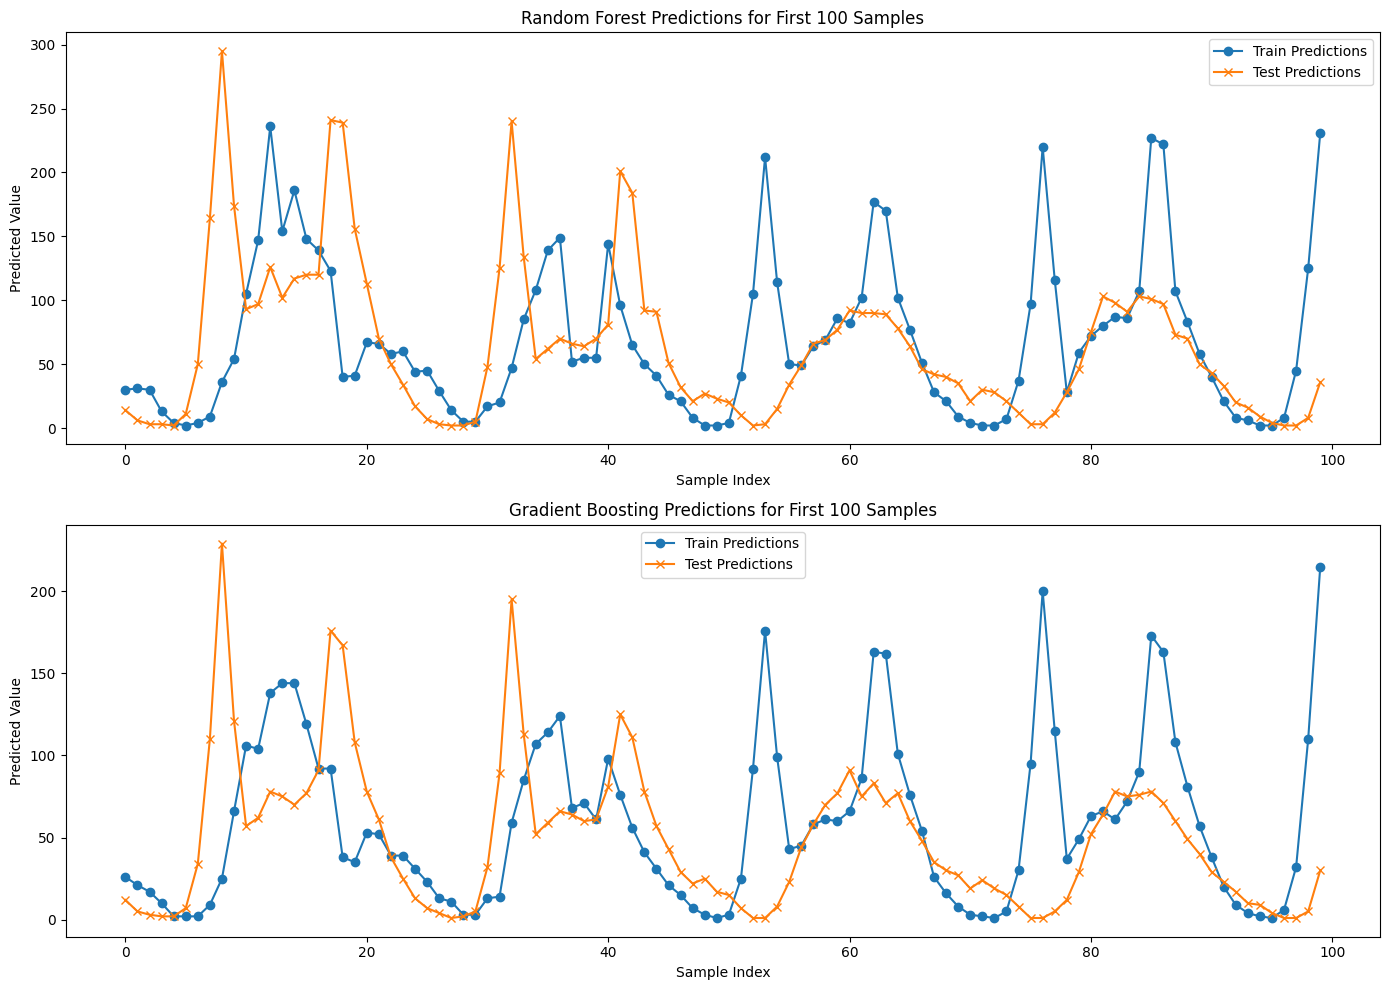

In [21]:
# Plot predictions for each model for the first 100 samples
plt.figure(figsize=(14, 10))
for clf_index, clf_name in enumerate(['Random Forest', 'Gradient Boosting']):
    plt.subplot(2, 1, clf_index+1)
    plt.plot(np.arange(100), blend_train[:100, clf_index], label='Train Predictions', marker='o')
    plt.plot(np.arange(100), blend_test[:100, clf_index], label='Test Predictions', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Value')
    plt.title(f'{clf_name} Predictions for First 100 Samples')
    plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# output predictions for submission
submit_stack_blend_df = test_df[['datetime', 'count']].copy()
submit_stack_blend_df['count'] = y_pred_blend
submit_stack_blend_df.to_csv('submission.csv', index=False)


# Conclusion

위의 실험을 통해 자전거는 날씨가 좋을 때, 주로 가을철에 더 많이 대여되는 것으로 나타났습니다. 평일에는 주로 아침/저녁에, 주말에는 주로 낮 시간대 라이딩을 위해 대여하는 것으로 나타났습니다. 또한 온도, 풍속, 습도 사이의 다양한 상관관계도 살펴봤습니다. 머신러닝 모델도 랜덤포레스트레그레서(RandomForestRegressor)를 사용해 개발했고, 그 정확도를 평가했습니다. 수동 및 선형 회귀 스태킹의 개념도 설명했습니다.  


정말 좋은 예제인 것은 분명하나 난이도가 어렵다 배울 점이 많다.